In [ ]:
!wget wget https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz

--2020-10-06 15:55:28--  http://wget/
Resolving wget (wget)... failed: Name or service not known.
wget: unable to resolve host address ‘wget’
--2020-10-06 15:55:28--  https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz
Resolving www.cs.toronto.edu (www.cs.toronto.edu)... 128.100.3.30
Connecting to www.cs.toronto.edu (www.cs.toronto.edu)|128.100.3.30|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 170498071 (163M) [application/x-gzip]
Saving to: ‘cifar-10-python.tar.gz’

cifar-10-python.tar 100%[===================>] 162.60M  74.5MB/s    in 2.2s    

2020-10-06 15:55:30 (74.5 MB/s) - ‘cifar-10-python.tar.gz’ saved [170498071/170498071]

FINISHED --2020-10-06 15:55:30--
Total wall clock time: 2.5s
Downloaded: 1 files, 163M in 2.2s (74.5 MB/s)


In [ ]:
!tar -xzvf /content/cifar-10-python.tar.gz

cifar-10-batches-py/
cifar-10-batches-py/data_batch_4
cifar-10-batches-py/readme.html
cifar-10-batches-py/test_batch
cifar-10-batches-py/data_batch_3
cifar-10-batches-py/batches.meta
cifar-10-batches-py/data_batch_2
cifar-10-batches-py/data_batch_5
cifar-10-batches-py/data_batch_1


In [ ]:
import cv2
from PIL import Image

In [ ]:
# Preparing datasets for further using
# Loading all batches and concatenating them all together
# Plotting first 100 examples of images from 10 different classes
# Preprocessing loaded CIFAR-10 dataset
# Saving datasets into file


"""Importing library for object serialization
which we'll use for saving and loading serialized models"""
import pickle

# Importing other standard libraries
import numpy as np
import os
import matplotlib.pyplot as plt


# Defining function for loading single batch of CIFAR-10 dataset
def single_batch_cifar10(file):
    # Opening file for reading in binary mode
    with open(file, 'rb') as f_single_batch:
        d_single_batch = pickle.load(f_single_batch, encoding='latin1')  # dictionary type, we use 'latin1' for python3
        x = d_single_batch['data']  # numpy.ndarray type, (10000, 3072)
        y = d_single_batch['labels']  # list type
        """Initially every batch's dictionary with key 'data' has shape (10000, 3072)
        Where, 10000 - number of image samples
        3072 - three channels of image (red + green + blue)
        Every row contains an image 32x32 pixels with its three channels"""
        # Here we reshape and transpose ndarray for further use
        # At the same time method 'astype()' used for converting ndarray from int to float
        # It is used further in function 'pre_process_cifar10' as it is needed to subtract float from float
        # And for standard deviation as it is needed to divide float by float
        x = x.reshape(10000, 3, 32, 32).transpose(0, 2, 3, 1).astype('float')  # (10000, 32, 32, 3)
        # Making numpy array from list of labels
        y = np.array(y)

        # Returning ready data
        return x, y


# Defining function for loading whole CIFAR-10 dataset
def whole_cifar10():
    # Defining lists for adding all batch's data all together
    x_collect = []
    y_collect = []

    # Defining lists for loading current batch
    x, y = [], []

    # Loading all 5 batches for training and appending them together
    for k in range(1, 6):
        # Preparing current filename
        filename = os.path.join('/content/cifar-10-batches-py', 'data_batch_' + str(k))
        # Loading current batch
        x, y = single_batch_cifar10(filename)
        # Appending data from current batch to lists
        x_collect.append(x)
        y_collect.append(y)

    # Concatenating collected data as list of lists as one list
    x_train = np.concatenate(x_collect)  # (50000, 32, 32, 3)
    y_train = np.concatenate(y_collect)  # (50000,)

    # Releasing memory from non-needed anymore arrays
    del x, y

    # Loading data for testing
    filename = os.path.join('/content/cifar-10-batches-py', 'test_batch')
    x_test, y_test = single_batch_cifar10(filename)
    
    # Returning whole CIFAR-10 data for training and testing
    return x_train, y_train, x_test, y_test

	
# Defining function for preprocessing CIFAR-10 dataset
def pre_process_cifar10():
    # Loading whole CIFAR-10 dataset
    x_train, y_train, x_test, y_test = whole_cifar10()

    # Normalizing whole data by dividing /255.0
    x_train /= 255.0
    x_test /= 255.0

    # Preparing data for training, validation and testing
    # Data for validation is taken with 1000 examples from training dataset in range from 49000 to 50000
    batch_mask = list(range(49000, 50000))
    x_validation = x_train[batch_mask]  # (1000, 32, 32, 3)
    y_validation = y_train[batch_mask]  # (1000,)
    # Data for training is taken with first 49000 examples from training dataset
    batch_mask = list(range(49000))
    x_train = x_train[batch_mask]  # (49000, 32, 32, 3)
    y_train = y_train[batch_mask]  # (49000,)
    # Data for testing is taken with first 1000 examples from testing dataset
    batch_mask = list(range(1000))
    x_test = x_test[batch_mask]  # (1000, 32, 32, 3)
    y_test = y_test[batch_mask]  # (1000,)

    # Normalizing data by subtracting mean image and dividing by standard deviation
    # Subtracting the dataset by mean image serves to center the data
    # It helps for each feature to have a similar range and gradients don't go out of control
    # Calculating mean image from training dataset along the rows by specifying 'axis=0'
    mean_image = np.mean(x_train, axis=0)  # numpy.ndarray (32, 32, 3)

    # Calculating standard deviation from training dataset along the rows by specifying 'axis=0'
    std = np.std(x_train, axis=0)  # numpy.ndarray (32, 32, 3)
    # Saving calculated 'mean_image' and 'std' into 'pickle' file
    # We will use them when preprocess input data for classifying
    # We will need to subtract and divide input image for classifying
    # As we're doing now for training, validation and testing data
    dictionary = {'mean_image': mean_image, 'std': std}
    with open('mean_and_std.pickle', 'wb') as f_mean_std:
        pickle.dump(dictionary, f_mean_std)

    # Subtracting calculated mean image from datasets
    x_train -= mean_image
    x_validation -= mean_image
    x_test -= mean_image

    # Dividing then every dataset by standard deviation
    x_train /= std
    x_validation /= std
    x_test /= std

    # Transposing every dataset to make channels come first
    x_train = x_train.transpose(0, 3, 1, 2)  # (49000, 3, 32, 32)
    x_test = x_test.transpose(0, 3, 1, 2)  # (1000, 3, 32, 32)
    x_validation = x_validation.transpose(0, 3, 1, 2)  # (1000, 3, 32, 32)

    # Returning result as dictionary
    d_processed = {'x_train': x_train, 'y_train': y_train,
                   'x_validation': x_validation, 'y_validation': y_validation,
                   'x_test': x_test, 'y_test': y_test}

    # Returning dictionary
    return d_processed


# Preprocessing data
data = pre_process_cifar10()
for i, j in data.items():
    print(i + ':', j.shape)

# x_train: (49000, 3, 32, 32)
# y_train: (49000,)
# x_validation: (1000, 3, 32, 32)
# y_validation: (1000,)
# x_test: (1000, 3, 32, 32)
# y_test: (1000,)

# Saving loaded and preprocessed data into 'pickle' file
with open('data.pickle', 'wb') as f:
    pickle.dump(data, f)

x_train: (49000, 3, 32, 32)
y_train: (49000,)
x_validation: (1000, 3, 32, 32)
y_validation: (1000,)
x_test: (1000, 3, 32, 32)
y_test: (1000,)


In [ ]:
x_train,y_train,x_test,y_test = whole_cifar10()

In [ ]:
y_train[5]

1

In [ ]:
x_train.shape

(50000, 32, 32, 3)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


True

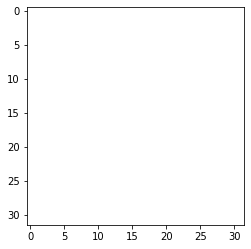

In [ ]:
im1 = x_train[1]
im1.shape
plt.imshow(im1)
cv2.imwrite("im.jpg",im1)

In [ ]:
im1[0]

array([[154., 177., 187.],
       [126., 137., 136.],
       [105., 104.,  95.],
       [102., 101.,  99.],
       [125., 131., 139.],
       [155., 166., 180.],
       [172., 190., 210.],
       [180., 199., 214.],
       [142., 156., 156.],
       [111., 120., 110.],
       [106., 107.,  98.],
       [109., 104., 102.],
       [123., 121., 117.],
       [127., 129., 127.],
       [181., 188., 189.],
       [217., 226., 229.],
       [209., 211., 211.],
       [166., 167., 162.],
       [164., 165., 156.],
       [158., 160., 148.],
       [116., 117., 103.],
       [102., 101.,  83.],
       [ 95.,  95.,  76.],
       [ 90.,  89.,  79.],
       [ 72.,  70.,  69.],
       [ 60.,  60.,  61.],
       [ 56.,  57.,  54.],
       [ 77.,  78.,  72.],
       [ 94.,  96.,  84.],
       [ 91.,  95.,  71.],
       [ 87.,  90.,  71.],
       [ 79.,  81.,  70.]])